In [1]:
import sys
sys.path.insert(0, '..')

import PipelineTS
PipelineTS.__version__

'0.3.10'

# Quickly test all available models using the ModelPipeline class

PipelineTS comes with a variety of built-in industrial datasets that can be directly loaded and utilized through the API.

In [2]:
import pandas as pd

from PipelineTS.dataset import LoadMessagesSentDataSets
from PipelineTS.plot import plot_data_period, plot_single_series

# load data
init_data = LoadMessagesSentDataSets()
print("data_name:", init_data.name, 
      "\ntime_col:", init_data.time_col, 
      "\ntarget_col:", init_data.target_col, 
      "\nfeature_cols:", init_data.feature_cols,
      "\ndata shape:", init_data.shape)

time_col = init_data.time_col
target_col = init_data.target_col

init_data = init_data[[time_col, target_col]]
# note that: when using PipelineTS for time series prediction,
#  it is necessary to convert the time feature column to the pandas datetime64[ns] format in advance
init_data[time_col] = pd.to_datetime(init_data[time_col])

data_name: Messages_Sent 
time_col: date 
target_col: tc 
feature_cols: ['ta', 'tb'] 
data shape: (602, 4)


## Plotting data

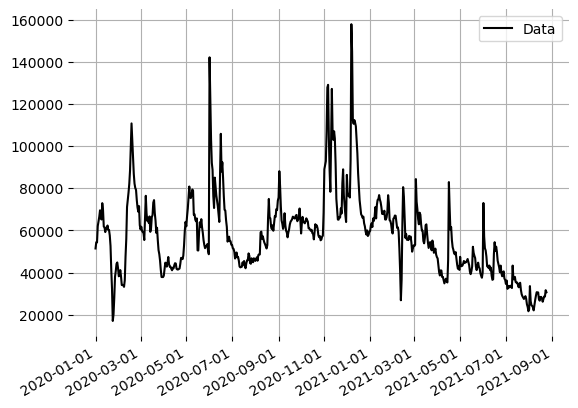

In [3]:
# docs for plot_single_series func
# Visualize time-series data.

# Parameters
# ----------
# series : pd.DataFrame
#     The dataset containing time-series data for plotting.
# time_col : str
#     Column name in the dataframes representing the time information.
# target_col : str
#     Column name in the dataframes representing the target variable.
# label : None or str, optional, default: None
#     Label for the plot. If None, default label 'Data' will be used.
# date_fmt : str, optional, default: '%Y-%m-%d'
#     Date format for the x-axis labels.

plot_single_series(init_data, time_col=time_col, target_col=target_col)

## list all available models

In [4]:
# dividing the training set and the validation set
valid_data = init_data.iloc[-30:, :]
data = init_data.iloc[:-30, :]

# set the computing device, which will specify the computing device for the neural network model
# default to 'auto'
accelerator = 'auto'  

# set the step size for prediction
n = 30

from PipelineTS.pipeline import ModelPipeline

# list all available models
ModelPipeline.list_all_available_models()

['auto_arima',
 'catboost',
 'd_linear',
 'gau',
 'lightgbm',
 'multi_output_model',
 'multi_step_model',
 'n_beats',
 'n_hits',
 'n_linear',
 'patch_rnn',
 'prophet',
 'random_forest',
 'regressor_chain',
 'stacking_rnn',
 'tcn',
 'tft',
 'tide',
 'time2vec',
 'transformer',
 'wide_gbrt',
 'xgboost']

## Training

In [5]:
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import QuantileTransformer

# Instantiate the ModelPipeline class. 
# If you haven't decided which model to use, you can directly use the ModelPipeline to test the prediction performance of available models in bulk.
# In fact, it is recommended that advanced users directly use the ModelPipeline to use the model, 
#   as the class has built-in feature preprocessing and developer's practical experience rules.

pipeline = ModelPipeline(
    time_col=time_col,  # The time column in the dataset must have a unique column name, and there can only be one time column in the dataset.
    target_col=target_col,  # Prediction target column in the dataset
    
    # This indicates the window size used when selecting historical data for model prediction. 
    # Generally, a longer window can provide the model with more historical information, 
    #   but this depends on whether the data has strong autocorrelation.
    lags=10,  
    
    # random seed
    random_state=42,
    
    # it can be one of the strings ‘light’, ‘all’, ‘nn’, or ‘ml’, or it is of type None or a list. Default to 'light'
    # It specifies which models are used for prediction, and the names include the following models:
    #   'light' for ['d_linear', 'lightgbm', 'multi_step_model', 'n_hits', 'n_linear', 'random_forest', 'regressor_chain', 'tcn', 'xgboost']
    #   'all' for the list of ModelPipeline.list_all_available_models()
    #   'nn' for ['d_linear', 'gau', 'n_beats', 'n_hits', 'n_linear', 'tcn', 'tft', 'patch_rnn', 'stacking_rnn', 'tide', 'time2vec', 'transformer']
    #   'ml' for ['catboost', 'lightgbm', 'multi_output_model', 'multi_step_model','random_forest', 'regressor_chain', 'wide_gbrt', 'xgboost']
    include_models='all',
    # Specify the performance evaluation criteria when training the model with the pipeline. The default is mean absolute error.
    metric=mean_absolute_error,
    # Is it better to have a lower performance evaluation standard
    metric_less_is_better=True,
    # set the computing device, which will specify the computing device for the neural network model
    accelerator=accelerator,
    
    # False for MinMaxScaler, True for QuantileTransformer, None means no data be scaled
    scaler=False
)

# Train all specified models.
pipeline.fit(data, valid_data=valid_data)

MPS  available: True   | MPS  use: True
CUDA available: False  | CUDA use: False
TPU  available: False  | TPU  use: False
CPU  available: True   | CPU  use: False

15:38:32 2023-11-24 - PipelineTS - There are a total of 22 models to be trained.
15:38:32 2023-11-24 - PipelineTS - [model  0] fitting and evaluating auto_arima...
15:38:51 2023-11-24 - PipelineTS - [model  1] fitting and evaluating catboost...
15:39:08 2023-11-24 - PipelineTS - [model  2] fitting and evaluating d_linear...
15:39:29 2023-11-24 - PipelineTS - [model  3] fitting and evaluating gau...
15:39:48 2023-11-24 - PipelineTS - [model  4] fitting and evaluating lightgbm...
15:40:01 2023-11-24 - PipelineTS - [model  5] fitting and evaluating multi_output_model...
15:40:12 2023-11-24 - PipelineTS - [model  6] fitting and evaluating multi_step_model...
15:40:22 2023-11-24 - PipelineTS - [model  7] fitting and evaluating n_beats...
15:41:00 2023-11-24 - PipelineTS - [model  8] fitting and evaluating n_hits...
15:41:22 2023-

Leaderboard,model,train_cost(s),eval_cost(s),metric
0,prophet,0.150168,0.060828,4217.385464
1,lightgbm,3.458282,0.047143,4814.501362
2,tcn,9.123009,0.114633,5729.533369
3,catboost,7.922536,0.042413,6316.244328
4,xgboost,2.083555,0.007892,7581.523372
5,time2vec,9.242139,0.142463,7735.137865
6,auto_arima,8.881055,0.029010,8081.000115
7,patch_rnn,19.315675,0.184171,9959.832855
8,wide_gbrt,10.206306,1.436362,10156.679334
9,tide,29.795122,0.134294,11716.335156


## Plotting the forecast results

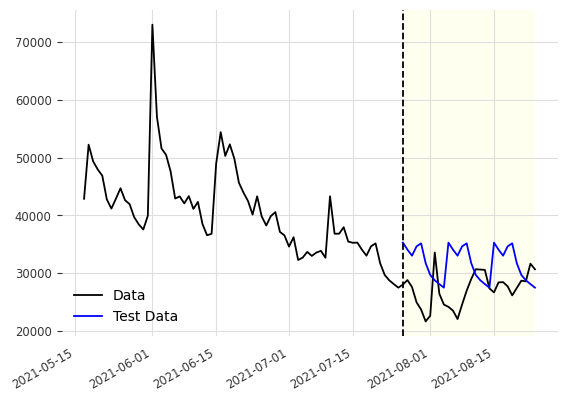

In [6]:
# use best model to predict next 30 steps data point
# You can use `model_name` to specify the pre-trained model in the pipeline when using Python.
prediction = pipeline.predict(30, model_name='tcn')

plot_data_period(init_data.iloc[-100:, :], prediction, 
                 time_col=time_col, target_col=target_col)

## Make predictions from the last timestamp of the specific sequence  

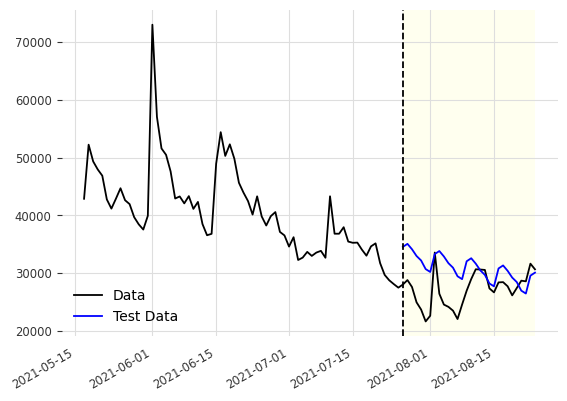

In [7]:
# use best model to predict next 30 steps data point
# You can use `model_name` to specify the pre-trained model in the pipeline when using Python.
prediction = pipeline.predict(n, data=init_data.iloc[-120:-90, :])  

plot_data_period(init_data.iloc[-100:, :], prediction, 
                 time_col=time_col, target_col=target_col)

## ModelPipeline saving and loading

In [8]:
from PipelineTS.io import load_model, save_model

# save
save_model(path='pipeline.zip', model=pipeline)
# load
pipeline = load_model('pipeline.zip')

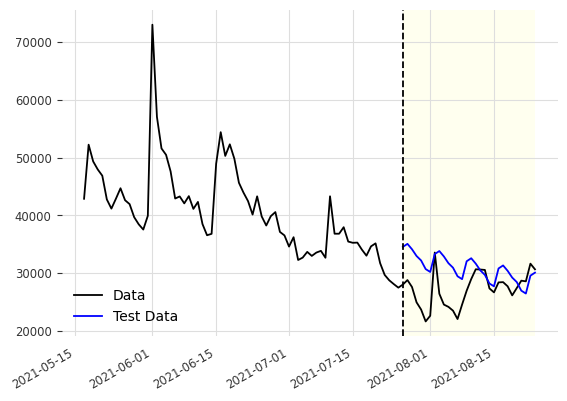

In [9]:
prediction = pipeline.predict(n, data=init_data.iloc[-90:-60, :])   

plot_data_period(init_data.iloc[-100:, :], prediction, 
                 time_col=time_col, target_col=target_col)

# Fit Data with a Single Estimator in the ModelPipeline Class

In [10]:
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import QuantileTransformer
from PipelineTS.nn_model import StackingRNNModel
from PipelineTS.pipeline import ModelPipeline

pipeline = ModelPipeline(
    time_col=time_col, 
    target_col=target_col, 
    lags=30,  
    random_state=42,
    # Specify the performance evaluation criteria when training the model with the pipeline. The default is mean absolute error.
    metric=mean_absolute_error,
    # Is it better to have a lower performance evaluation standard
    metric_less_is_better=True,
    # set the computing device, which will specify the computing device for the neural network model
    accelerator=accelerator,
    
    # False for MinMaxScaler, True for QuantileTransformer, None means no data be scaled
    scaler=False,

    # include_models : {'light', 'all', 'nn', 'ml'} or list or None or a available model of PipelineTS, optional, default: 'light'
    #   Models to include in the pipeline.
    include_models=StackingRNNModel,
    StackingRNNModel__dropout=0.2
)

# Train all specified models.
pipeline.fit(data, valid_data=valid_data)

MPS  available: True   | MPS  use: True
CUDA available: False  | CUDA use: False
TPU  available: False  | TPU  use: False
CPU  available: True   | CPU  use: False

15:48:14 2023-11-24 - PipelineTS - There are a total of 1 models to be trained.
15:48:14 2023-11-24 - PipelineTS - [model 0] fitting and evaluating StackingRNNModel...


Leaderboard,model,train_cost(s),eval_cost(s),metric
0,StackingRNNModel,15.009838,0.009708,6440.094448


# Fit data with a Single Model

In [11]:
from PipelineTS.nn_model import DLinearModel

In [12]:
model = DLinearModel(time_col, target_col, lags=16, quantile=0.9, random_state=42)

In [13]:
model.fit(data, valid_data=valid_data)

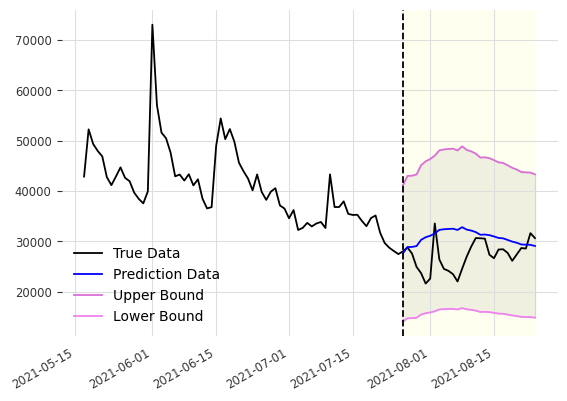

In [14]:
# evaluate 
prediction = model.predict(30)  

plot_data_period(init_data.iloc[-100:, :], prediction, 
                 time_col=time_col, target_col=target_col)